In [52]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [53]:
import sys # needed to import cat_utils
sys.path.insert(0, '/Users/abrahamn/21cmIR/21cmIRxcor/')

import imp
import cat_utils
imp.reload(cat_utils)

from astropy.table import Table

In [3]:
mwa_cat = cat_utils.MWACatalog('mwa_calibration_source_list.sav')

In [4]:
#t = Table.read('/Volumes/abraham/xcor_data/far_ir_catalogs/wise_allsky.allsky_4band_p3as_psd31177.tbl', format='ipac') # WISE
t = Table.read('/Volumes/abraham/xcor_data/far_ir_catalogs/wise_allwise.wise_allwise_p3as_psd18333.tbl', format='ipac') # ALLWISE

In [5]:
t.dtype

dtype([('ra', '<f8'), ('dec', '<f8'), ('w1mpro', '<f8'), ('w1sigmpro', '<f8'), ('w1snr', '<f8'), ('w2mpro', '<f8'), ('w2sigmpro', '<f8'), ('w3mpro', '<f8'), ('w3sigmpro', '<f8'), ('w4mpro', '<f8'), ('w4sigmpro', '<f8'), ('cc_flags', 'S4')])

In [8]:
ra = t['ra'].data.data
ra[ra>180] -= 360
dec = t['dec'].data.data
w1_mag = t['w1mpro'].data.data
w2_mag = t['w2mpro'].data.data
w3_mag = t['w3mpro'].data.data
w4_mag = t['w4mpro'].data.data

# the mag uncertainty columns have a 'null' (which python reads as a 0) if the 
# mag is actually a 95% upper limit (ie, if the source is not actually detected)
w1_dmag = t['w1sigmpro'].data.data
w2_dmag = t['w2sigmpro'].data.data
w3_dmag = t['w3sigmpro'].data.data
w4_dmag = t['w4sigmpro'].data.data

g1 = (w1_dmag!=0)
g2 = (w2_dmag!=0)
g3 = (w3_dmag!=0)
g4 = (w4_dmag!=0)

w1_jy = 309.54*10.**(-w1_mag/2.5) # these numbers are from http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
w2_jy = 171.787*10.**(-w2_mag/2.5)
w3_jy = 31.674*10.**(-w3_mag/2.5)
w4_jy = 8.363*10.**(-w4_mag/2.5)

In [9]:
wisecats = [cat_utils.Catalog(ra[g1],dec[g1],w1_jy[g1]),\
           cat_utils.Catalog(ra[g2],dec[g2],w2_jy[g2]),\
           cat_utils.Catalog(ra[g3],dec[g3],w3_jy[g3]),\
           cat_utils.Catalog(ra[g4],dec[g4],w4_jy[g4])]
mwa_cat_wise = mwa_cat.limit_to_ra_dec_min_max_of_other_cat(wisecats[0])

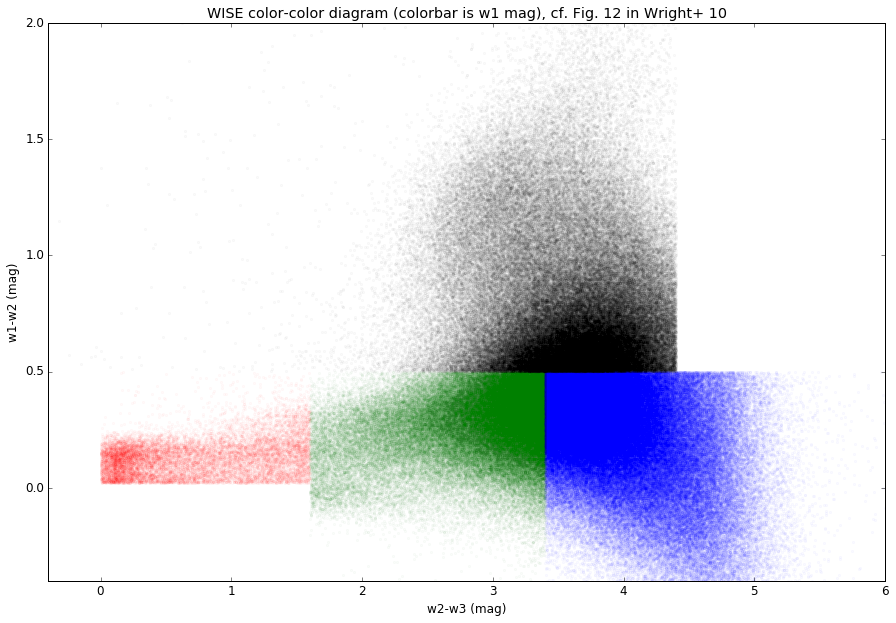

In [116]:

gall = g1&g2&g3

# these are the four regions in Fig. 2 of 1607.06471
g_types = [(w1_mag-w2_mag<.5)&(0<w2_mag-w3_mag)&(w2_mag-w3_mag<1.6)&(w1_mag-w2_mag>.02),\
          (w1_mag-w2_mag<0.5)&(1.6<w2_mag-w3_mag)&(w2_mag-w3_mag<3.4),\
          (w1_mag-w2_mag<.5)&(w2_mag-w3_mag>3.4),\
          (w1_mag-w2_mag>.5)&(w2_mag-w3_mag<4.4)]
g_names = ['ellipticals','spirals','starburst','AGN']

plt.figure(figsize=(15,10))
cols=['r','g','b','k']
for gi in range(len(g_types)):
    plt.scatter(w2_mag[gall&g_types[gi]]-w3_mag[gall&g_types[gi]],w1_mag[gall&g_types[gi]]-w2_mag[gall&g_types[gi]],5,color=cols[gi],alpha=.02)
plt.xlim([-.4,6])
plt.ylim([-.4,2])
plt.xlabel('w2-w3 (mag)')
plt.ylabel('w1-w2 (mag)')
plt.title('WISE color-color diagram (colorbar is w1 mag), cf. Fig. 12 in Wright+ 10')

In [117]:
dtheta_deg = 5./60

In [132]:
# make WISE images

for gi in range(len(g_types)):
    wisecatfilt = cat_utils.Catalog(ra[gall&g_types[gi]],dec[gall&g_types[gi]],w1_jy[gall&g_types[gi]])
    wisecatfilt_img = cat_utils.cat2img(wisecatfilt,bound_cat=wisecats[0],dtheta=dtheta_deg,\
                                       jymin=np.percentile(wisecatfilt.jy,10),\
                                       jymax=np.percentile(wisecatfilt.jy,90),verbose=True)
    np.savez('/volumes/abraham/xcor_data/far_ir_catalogs/W1_gi='+str(gi)+'.npz',wisecatfilt_img)

0.0
0.0934579439252
0.18691588785
0.280373831776
0.373831775701
0.467289719626
0.560747663551
0.654205607477
0.747663551402
0.841121495327
0.934579439252
0.0
0.0934579439252
0.18691588785
0.280373831776
0.373831775701
0.467289719626
0.560747663551
0.654205607477
0.747663551402
0.841121495327
0.934579439252
0.0
0.0934579439252
0.18691588785
0.280373831776
0.373831775701
0.467289719626
0.560747663551
0.654205607477
0.747663551402
0.841121495327
0.934579439252
0.0
0.0934579439252
0.18691588785
0.280373831776
0.373831775701
0.467289719626
0.560747663551
0.654205607477
0.747663551402
0.841121495327
0.934579439252


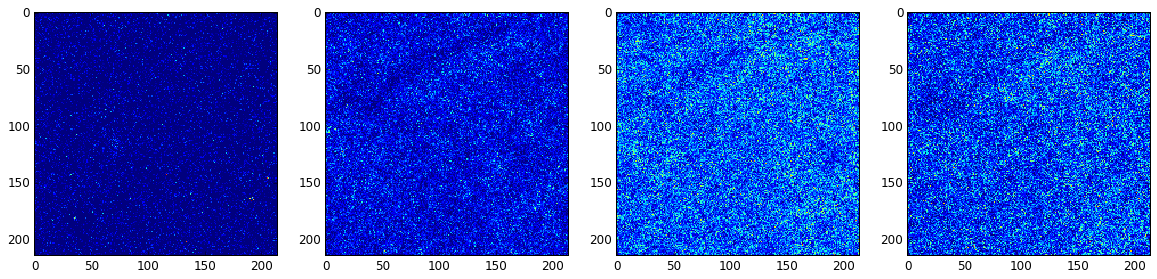

In [133]:
# plot WISE images

plt.figure(figsize=(20,5))
for gi in range(len(g_types)):
    ir_img = np.load('/volumes/abraham/xcor_data/far_ir_catalogs/W1_gi='+str(gi)+'.npz')['arr_0']
    
    plt.subplot(1,len(g_types),gi+1)
    plt.imshow(ir_img,interpolation='nearest')

In [134]:
mwa_percentile_limits = [95]
cols = ['b']
[np.sum(mwa_cat_wise.jy<np.percentile(mwa_cat_wise.jy,mwa_percentile_limits[l])) for l in range(len(mwa_percentile_limits))]

[1830]

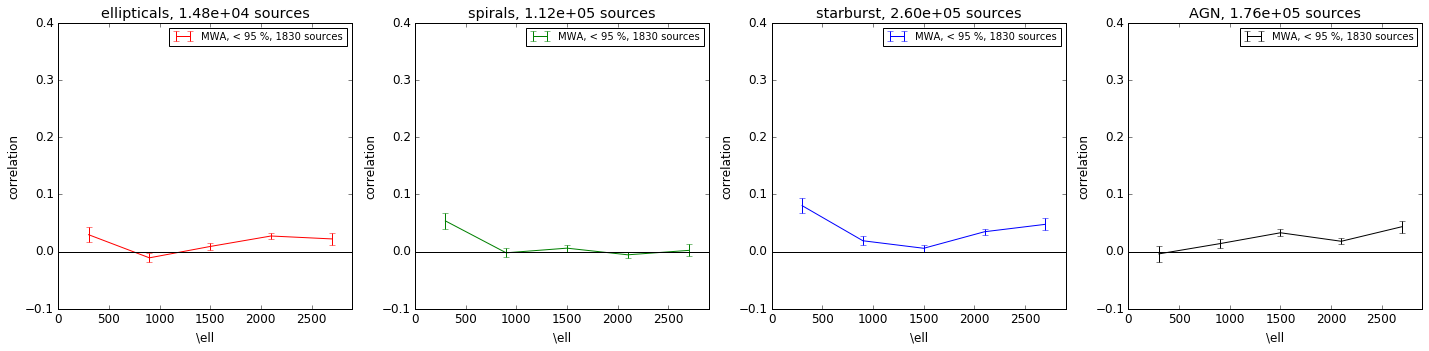

In [135]:
# plot correlations

nbins = 5
lmax = 3000

plt.figure(figsize=(20,5))
matplotlib.rcParams.update({'font.size': 12})

cols=['r','g','b','k']
for mwa_percentile_limiti in range(len(mwa_percentile_limits)):
    
    mwa_img = cat_utils.cat2img(mwa_cat_wise,bound_cat=wisecats[0],dtheta=dtheta_deg,\
                                jymin=np.percentile(mwa_cat_wise.jy,10),\
                                jymax=np.percentile(mwa_cat_wise.jy,90))
    
    for gi in range(4):
            
        ir_img = np.load('/volumes/abraham/xcor_data/far_ir_catalogs/W1_gi='+str(gi)+'.npz')['arr_0']

        lbins,pspec1,pspec2,xspec,bin_counts = cat_utils.calc_xspec(ir_img,mwa_img,dtheta_deg,nbins,lmax,hann=True)
        c = xspec/np.sqrt(pspec1*pspec2)


        plt.subplot(1,len(g_types),1+gi)
        
        l = 'MWA, < %d %%, %d sources'%(mwa_percentile_limits[mwa_percentile_limiti],\
                                                          np.sum(mwa_cat_wise.jy<np.percentile(mwa_cat_wise.jy,mwa_percentile_limits[mwa_percentile_limiti])))
        plt.errorbar(lbins,c,np.sqrt(.5*(1+c**2)/bin_counts),color=cols[gi],label=l)

        plt.xlim([0,200+np.max(lbins)])
        plt.ylim([-.1,.4])
        plt.xlabel('\ell')
        plt.ylabel('correlation')
        plt.title('%s, %1.2e sources'%(g_names[gi],np.sum(g3&g_types[gi])))
        plt.plot([0,5000],[0,0],'k-')

        plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('MWA_ALLWISE_xcor_by_source_type.png',bbox_inches='tight')

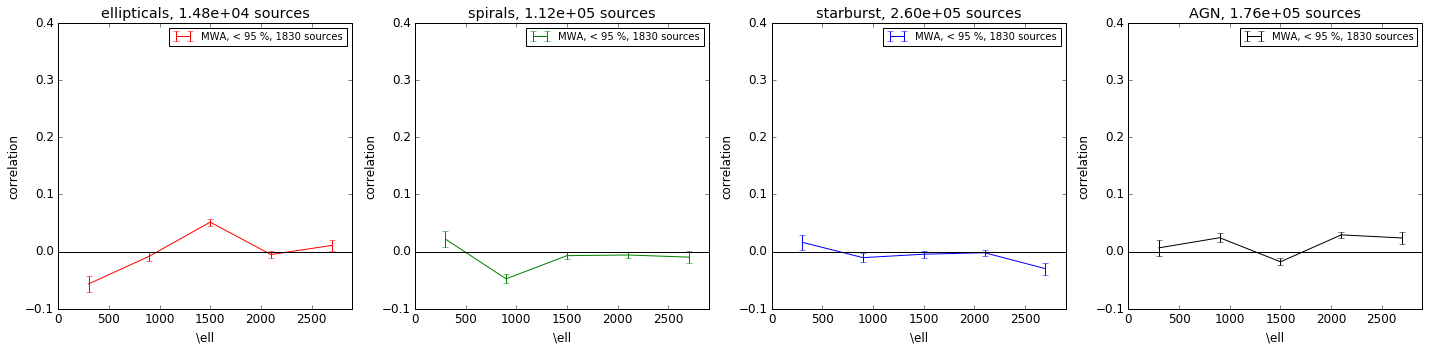

In [136]:
# plot correlations

nbins = 5
lmax = 3000

plt.figure(figsize=(20,5))
matplotlib.rcParams.update({'font.size': 12})

cols=['r','g','b','k'] 
for mwa_percentile_limiti in range(len(mwa_percentile_limits)):
    
    mwa_img = cat_utils.cat2img(mwa_cat_wise,bound_cat=wisecats[0],dtheta=dtheta_deg,\
                                jymin=np.percentile(mwa_cat_wise.jy,10),\
                                jymax=np.percentile(mwa_cat_wise.jy,90))
    
    for gi in range(4):
            
        ir_img = np.load('/volumes/abraham/xcor_data/far_ir_catalogs/W1_gi='+str(gi)+'.npz')['arr_0']

        lbins,pspec1,pspec2,xspec,bin_counts = cat_utils.calc_xspec(np.flipud(ir_img),mwa_img,dtheta_deg,nbins,lmax,hann=True)
        c = xspec/np.sqrt(pspec1*pspec2)


        plt.subplot(1,len(g_types),1+gi)
        
        l = 'MWA, < %d %%, %d sources'%(mwa_percentile_limits[mwa_percentile_limiti],\
                                                          np.sum(mwa_cat_wise.jy<np.percentile(mwa_cat_wise.jy,mwa_percentile_limits[mwa_percentile_limiti])))
        plt.errorbar(lbins,c,np.sqrt(.5*(1+c**2)/bin_counts),color=cols[gi],label=l)

        plt.xlim([0,200+np.max(lbins)])
        plt.ylim([-.1,.4])
        plt.xlabel('\ell')
        plt.ylabel('correlation')
        plt.title('%s, %1.2e sources'%(g_names[gi],np.sum(g3&g_types[gi])))
        plt.plot([0,5000],[0,0],'k-')

        plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('MWA_ALLWISE_xcor_by_source_type_flipud.png',bbox_inches='tight')